In [131]:
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


In [132]:
# read all tables
customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')


marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

# step 3: set customers and engagement index as customer_id
customers.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

merged_df = customers.join(engagement).join(transactions_agg).join(marketing_agg)
merged_df

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [133]:

transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
transactions

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics
...,...,...,...,...,...
129540,129541,10000,2023-05-27,371.70,Home Goods
129541,129542,10000,2023-06-11,1245.23,Electronics
129542,129543,10000,2023-06-28,745.74,Electronics
129543,129544,10000,2023-07-21,587.37,Home Goods


In [134]:
#Cohort Analysis - #Onlu customers who have joined at a specific business day

cx_first_purchase_tbl = transactions.sort_values(['customer_id', 'transaction_date']).groupby('customer_id').first()
cx_first_purchase_tbl

,transaction_id,transaction_date,transaction_amount,product_category
customer_id,,,,
1,6,2024-01-09,174.72,Clothing
2,11,2021-09-29,1866.56,Electronics
3,19,2021-09-28,347.76,Clothing
4,29,2022-01-11,154.63,Electronics
5,42,2022-03-02,1977.50,Electronics
...,...,...,...,...
9996,129505,2023-01-01,438.60,Clothing
9997,129510,2022-07-15,248.05,Clothing
9998,129523,2023-11-13,1863.82,Electronics


In [135]:
cx_first_purchase_tbl.min()

transaction_id                          6
transaction_date      2020-01-06 00:00:00
transaction_amount                  10.05
product_category                 Clothing
dtype: object

In [136]:
cx_first_purchase_tbl.max()

transaction_id                     129541
transaction_date      2024-05-31 00:00:00
transaction_amount                1999.51
product_category               Home Goods
dtype: object

<Axes: xlabel='transaction_date'>

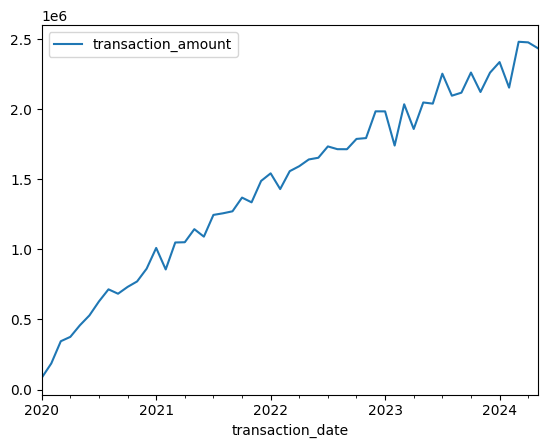

In [137]:
#Visualize all purchases within cohort
transactions.reset_index().set_index('transaction_date')[['transaction_amount']].resample(rule="MS").sum().plot()

In [138]:
#Visualize Individual Customer Purchases

ids = transactions['customer_id'].unique()
ids_selected = ids[0:10]
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [139]:
transactions_cx_id_subset = transactions[transactions['customer_id'].isin(ids_selected)].groupby(['customer_id','transaction_date']).sum().reset_index()
transactions_cx_id_subset

,customer_id,transaction_date,transaction_id,transaction_amount,product_category
0,1,2024-01-09,6,174.72,Clothing
1,1,2024-01-20,4,927.46,Electronics
2,1,2024-02-03,1,165.56,Clothing
3,1,2024-02-25,5,1395.87,Electronics
4,1,2024-03-02,2,699.01,Home Goods
...,...,...,...,...,...
119,9,2023-04-09,122,188.05,Electronics
120,9,2023-05-14,123,516.09,Electronics
121,9,2023-07-30,103,252.74,Home Goods
122,10,2021-10-08,125,229.09,Clothing


In [140]:
#Frame the problem
#What will the customer spend in the next 90-days (Regression)
#What is the probability of a customer to make a purchase in the next 90-days? (Classification) - Binary problem, they buy or they dont buy

#Time Splitting - Temporal splitting

n_days = 90
max_date = transactions['transaction_date'].max() ## May 31, 2024
cutoff = max_date - pd.to_timedelta(n_days, unit="d")


In [141]:
temporal_in_df = transactions[transactions['transaction_date'] <= cutoff] #Using this to predict the output
temporal_out_df = transactions[transactions['transaction_date'] > cutoff] #Predicting the output


In [142]:
# Feature Engineering (RFM) - Make targets from out data

targets_df = temporal_out_df.drop(columns=['transaction_date','transaction_id','product_category'], axis=1).groupby('customer_id').sum()\
    .rename({'transaction_amount' : '90_day_spend_total'}, axis=1).assign(spend_90_flag = 1)

targets_df

,90_day_spend_total,spend_90_flag
customer_id,,
1,146.86,1
7,1018.16,1
21,148.29,1
37,2136.82,1
38,299.14,1
...,...,...
9956,318.59,1
9973,4729.27,1
9976,456.78,1


In [143]:
#Make Recency (Date) Features from in data

max_date = temporal_in_df['transaction_date'].max()

recency_features_df = temporal_in_df[['customer_id', 'transaction_date']].groupby('customer_id')\
                                    .apply(
                                        lambda x: (x['transaction_date'].max() - max_date) / pd.to_timedelta(1, "day"))\
                                    .to_frame()\
                                    .set_axis(['recency'], axis=1)

recency_features_df

/var/folders/0q/z048sjx17mz9yrftyzsvw98r0000gp/T/ipykernel_4437/3671704765.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recency_features_df = temporal_in_df[['customer_id', 'transaction_date']].groupby('customer_id')\


,recency
customer_id,
1,0.0
2,-370.0
3,-470.0
4,-549.0
5,-275.0
...,...
9996,-265.0
9997,-450.0
9998,-61.0


In [144]:
#Make Frequency (Count) Features from in data

frequency_features_df = temporal_in_df[['customer_id', 'transaction_date']].groupby('customer_id').count().set_axis(['frequency'], axis=1)
frequency_features_df

,frequency
customer_id,
1,5
2,9
3,6
4,20
5,24
...,...
9996,10
9997,12
9998,3


In [145]:
# Make Monetary (Total amount) features from in data

monetary_features_df = temporal_in_df.groupby('customer_id').aggregate({'transaction_amount': ['sum', 'mean']}).set_axis(['price_sum', 'price_mean'], axis=1)
monetary_features_df

,price_sum,price_mean
customer_id,,
1,3362.62,672.524000
2,6081.32,675.702222
3,1454.87,242.478333
4,7874.68,393.734000
5,15524.55,646.856250
...,...,...
9996,5498.20,549.820000
9997,5848.30,487.358333
9998,3503.13,1167.710000


In [146]:
# COMBINE FEATURES ---------- #Flag shows if they spent money

features_df = pd.concat([recency_features_df, frequency_features_df, monetary_features_df], axis = 1).merge(targets_df,left_index= True, right_index=True, how='left').fillna(0)
features_df

,recency,frequency,price_sum,price_mean,90_day_spend_total,spend_90_flag
customer_id,,,,,,
1,0.0,5,3362.62,672.524000,146.86,1.0
2,-370.0,9,6081.32,675.702222,0.00,0.0
3,-470.0,6,1454.87,242.478333,0.00,0.0
4,-549.0,20,7874.68,393.734000,0.00,0.0
5,-275.0,24,15524.55,646.856250,0.00,0.0
...,...,...,...,...,...,...
9996,-265.0,10,5498.20,549.820000,0.00,0.0
9997,-450.0,12,5848.30,487.358333,0.00,0.0
9998,-61.0,3,3503.13,1167.710000,0.00,0.0


In [147]:
# MACHINE LEARNING ----

X = features_df[['recency', 'frequency', 'price_sum', 'price_mean']]

# NEXT 90-DAY SPEND prediction

y_spend = features_df['90_day_spend_total']
y_spend


customer_id
1        146.86
2          0.00
3          0.00
4          0.00
5          0.00
          ...  
9996       0.00
9997       0.00
9998       0.00
9999       0.00
10000      0.00
Name: 90_day_spend_total, Length: 9389, dtype: float64

In [149]:
#Fit the data
X_train, X_test, y_train, y_test = train_test_split(X, y_spend, test_size=0.3, random_state=1234)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=1234)
model.fit(X_train, y_train)

# Make predictions on the test set
y_reg_predictor = model.predict(X_test)
y_reg_predictor

array([1210.4855,    0.    ,    0.    , ...,    0.    ,  172.8572,
          0.    ])

In [150]:
# Evaluate the regression model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 279.22413993610223
Mean Squared Error (MSE): 825270.0678657367
Root Mean Squared Error (RMSE): 908.4437615316298
R-squared (R²): 0.3562302648539415


In [ ]:
# NEXT 90-DAY SPEND PROBABILITY

y_prob = features_df['spend_90_flag']

model_2 = LogisticRegression()

model_2.fit(X,y_prob)

LogisticRegression()

In [ ]:
model_2.predict(X,y_prob)

TypeError: predict() takes 2 positional arguments but 3 were given